# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [30]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval
import importlib
from datetime import datetime
import soundfile as sf

import audio_functions as af
import audio_models
import dataset

In [2]:
importlib.reload(audio_models)

<module 'audio_models' from '/home/enterprise.internal.city.ac.uk/acvn728/MScFinalProject/audio_models.py'>

### Get the variables and data ready

In [36]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 25
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
data_type = 'mag'

checkpoint = '169/169-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/NewCHiME/et05_bus_simu'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/NewCHiME/et05_bth'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/NewCHiME/et05_bus_bg'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type == 'mag_real_imag':
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [37]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, 'unet', is_training, learning_rate, 
                                    data_type, name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


In [38]:
model.voice_mask_network.decoder.output.shape

TensorShape([Dimension(None), Dimension(256), Dimension(512), Dimension(1)])

### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [39]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/169/169-8


### Run a batch

In [40]:
sess.run(pipe.initializer)
mix_inp, mix_phase, voice_inp, voice_est, \
mask, voice_wave, mix_wave, background_wave = sess.run([model.mixed_input, 
                                                        model.mixed_phase, 
                                                        model.voice_input,
                                                        model.gen_voice, 
                                                        model.voice_mask, 
                                                        model.voice_audio, 
                                                        model.mixed_audio,
                                                        model.background_audio],
                                                       {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_inp.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est[i, :, :, 0]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, 0]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [41]:
i=0
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

25
65280


In [42]:
# Infer the estimated background noise by subtracting estimated voice from mixed signal

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = af.normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = af.normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = af.normalise_audio(mix_wave[i,:,:])
    background_wave[i,:,:] = af.normalise_audio(background_wave[i,:,:])

bg_est_wave = mix_wave - voice_est_wave

# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], background_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

/home/enterprise.internal.city.ac.uk/acvn728/.local/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[15.50406088  8.92868077]
 [13.24364369  8.39911646]
 [10.10519009  8.37705685]
 [15.53756335 13.67654289]
 [13.53970662  7.83823228]
 [12.30372469  7.84932996]
 [ 9.05210342 10.27465711]
 [ 9.34732763  5.58435213]
 [ 7.34683901  4.76172885]
 [11.43643701  6.21097516]
 [11.27775934  3.88172909]
 [11.93203601  5.18445384]
 [ 9.11860612  5.32739804]
 [13.77721393  7.1933066 ]
 [10.93699202  6.92024555]
 [15.04419902  9.03652563]
 [14.66520272  7.71801287]
 [ 7.25486297  6.94555449]
 [12.40295279  6.0189348 ]
 [13.54347578  4.10881228]
 [13.01622306 11.09684508]
 [13.62408745 11.51231332]
 [11.0780529  10.20683131]
 [12.22193765  4.1366732 ]
 [12.16169516  4.69526414]] 
SIR
 [[19.74782738 15.53580127]
 [16.63222105 14.68664823]
 [13.74649087 19.25680876]
 [21.57366522 16.42498951]
 [16.84502601 13.82512697]
 [17.07802913 12.46941052]
 [13.69150983 16.04473708]
 [16.46969319  7.40531857]
 [13.05742361  7.1343726 ]
 [18.25254448  8.99662324]
 [16.68418871 

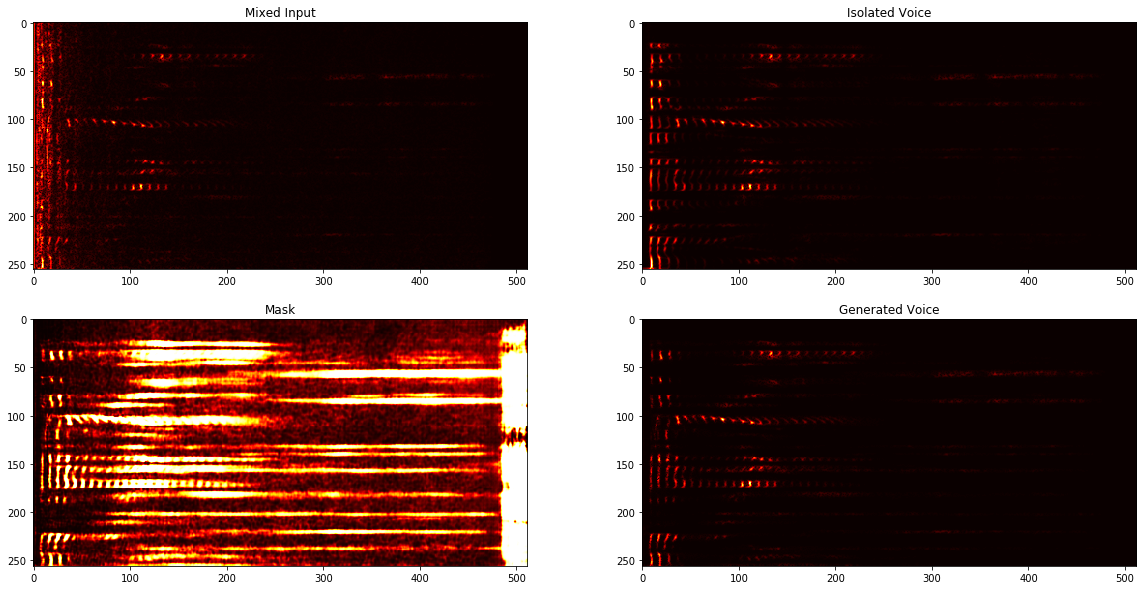

In [43]:
i=7

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_inp[i,:,:,0])
ax[0,0].set_title('Mixed Input')
ax[0,1].imshow(voice_inp[i,:,:,0])
ax[0,1].set_title('Isolated Voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('Mask')
ax[1,1].imshow(voice_est[i,:,:,0])
ax[1,1].set_title('Generated Voice')
plt.show()

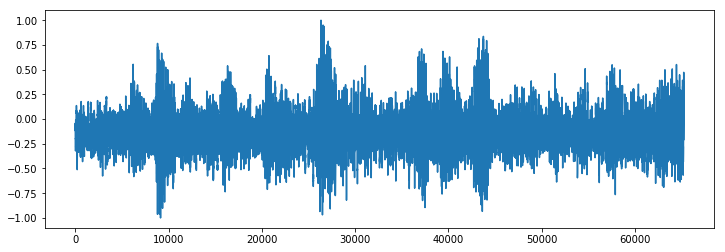

In [44]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

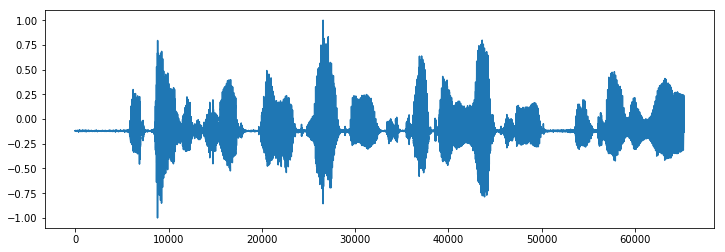

In [45]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

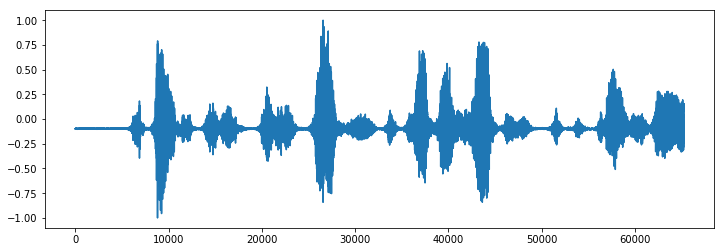

In [46]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

In [47]:
folder = 'audio_examples'
sf.write(os.path.join(folder,'mix_example_2.wav'), mix_wave[i], sample_rate)
sf.write(os.path.join(folder,'voice_example_2.wav'), voice_wave[i], sample_rate)
sf.write(os.path.join(folder,'voice_est_mag_example_2.wav'), voice_est_wave[i], sample_rate)


In [ ]:
sess.run(pipe.initializer)
print('start: {}'.format(datetime.now()))
epochs = 500
epoch = 0
epoch_cost = []
epoch_m_loss = []
epoch_p_loss = []
i = 0
while epoch < epochs:
    try:
        _, cost = sess.run([model.train_op, model.cost], {model.is_training:True})
        #_, cost, m_loss, p_loss = sess.run([model.train_op, model.cost, model.mag_loss, model.phase_loss], {model.is_training:True})
        #print('Iteration {i}: {dt}\nCost: {c}'.format(i=i, dt=datetime.datetime.now(), c=cost))
        epoch_cost.append(cost)
        #epoch_m_loss.append(m_loss)
        #epoch_p_loss.append(p_loss)
        i += 1
    except tf.errors.OutOfRangeError:
        epoch_mean_cost = sum(epoch_cost)/len(epoch_cost)
        #epoch_mean_m_loss = sum(epoch_m_loss)/len(epoch_m_loss)
        #epoch_mean_p_loss = sum(epoch_p_loss)/len(epoch_p_loss)
        print('Epoch {e} finished. Mean cost = {emc}'.format(e=epoch, emc=epoch_mean_cost))
        #print('\tMean magnitude loss = {emml}\n\tMean phase loss = {empl}'.format(emml=epoch_mean_m_loss,
        #                                                                       empl=epoch_mean_p_loss))
        epoch += 1
        sess.run(pipe.initializer)
print('finish: {}'.format(datetime.now()))